In [1]:
%matplotlib notebook
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt
import copy



Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


*************************************************************

Loading Abaqus-mesh from meshes/3D_simple_bladed_disk_24_sectors_1524_nodes.inp
Can not read the given string list
WARNING! 3D case were selected
Mesh meshes/3D_simple_bladed_disk_24_sectors_1524_nodes.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


<IPython.core.display.Javascript object>


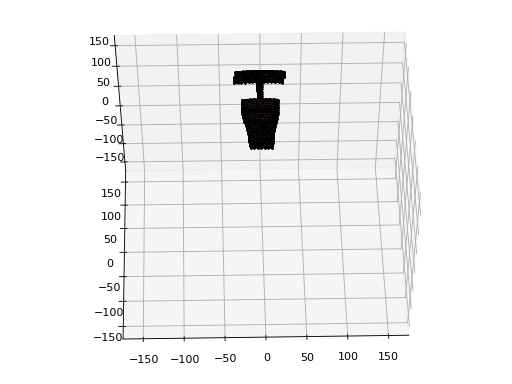

(-200, 200)

In [2]:
mesh_file = 'meshes/3d_simple_bladed_disk_24_sector.msh'
mesh_file = 'meshes/3D_simple_bladed_disk_24_sectors_course_v3.inp'
mesh_file = 'meshes/3D_simple_bladed_disk_24_sectors_1524_nodes.inp'
scale = 1000
m1 = amfe.Mesh()
#m1.import_msh(mesh_file)
m1.import_inp(mesh_file,scale)

ax1 = amfe.plot3Dmesh(m1)
bc = np.array([-200,200])
ax1.set_xlim(bc)
ax1.set_ylim(bc)
ax1.set_zlim(bc)

In [3]:
m1.get_phys_group_types()

{'BODY_1_1_ELSET',
 'BODY_1_1_SOLID_ELSET',
 'DIRICHLET_ELSET',
 'LEFT_ELSET',
 'RIGHT_ELSET'}

In [ ]:
m1.change_tag_in_eldf('phys_group','TOP_HIGH_ELSET',2)
m1.change_tag_in_eldf('phys_group','TOP_LOW_ELSET',3)
m1.change_tag_in_eldf('phys_group','BODY_1_1_SOLID_ELSET',4)
m1.change_tag_in_eldf('phys_group','LEFT_ELSET',3)
m1.change_tag_in_eldf('phys_group','RIGHT_ELSET',2)
m1.change_tag_in_eldf('phys_group','DIRICHLET_ELSET',1)

In [ ]:
Nsectors = 24
np.random.seed(1)
scale_list = 0.5*np.ones(Nsectors) + 0.5*np.random.rand(Nsectors)
base = np.array([1,1,1])
facecolor_list = []
mesh_list=[]
count=0
for i in range(Nsectors):
    mi = m1.rot_z(i*360/Nsectors)
    mesh_list.append(mi) 
    facecolor_list.append(scale_list[count]*base)
    count+=1
#mesh_list = [m1,m2]

fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(1,1,1, projection='3d')
for mi in mesh_list :
    amfe.plot3Dmesh(mi,ax=ax1)

plt.legend('off')

In [ ]:
m1.get_phys_group_types()

# Solving Static Problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{f}  \\
\mathbf{0}   
\end{bmatrix}
$$

In [ ]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(4,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()




In [ ]:
system_list = []
for mi in mesh_list:
    sysi = amfe.MechanicalSystem()
    sysi.set_mesh_obj(mi)
    sysi.set_domain(3,my_material)
    system_list.append(sysi)
#K2, _ = my_system2.assembly_class.assemble_k_and_f()
#M2 = my_system2.assembly_class.assemble_m()

In [ ]:
try:
    connectivity = []
    for _,item in m1.el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m1.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m1.el_df)

neighbors_dict = {}
neighbors_dict['right'] = 2
neighbors_dict['left'] = 1
neighbors_dict['top'] = 5
neighbors_dict['bottom'] = 4
neighbors_dict['bottom_left_corner'] = 6
neighbors_dict['bottom_right_corner'] = 7
neighbors_dict['top_left_corner'] = 8
neighbors_dict['top_right_corner'] = 9

B_local_dict = {}
for key, value in neighbors_dict.items():
    B_local_dict[key] = s.build_B(value)

In [ ]:
zeros = np.zeros(K1.shape[0])
case = FETIcase_builder(domains_X,domains_Y, K1, zeros, B_local_dict,s,BC_type='G',force_scaling=1.0)
K_dict, B_dict, f_dict = case.build_subdomain_matrices()

In [ ]:
feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-6)
solution_obj = feti_obj.solve()
u_dict = solution_obj.u_dict

for i,sysi in enumerate(system_list):
    sysi.u_output = [u_dict[i+1]]


In [ ]:
p0=1
fig, ax2 = plt.subplots(1,1,figsize=(10,3))
for i,sysi in enumerate(system_list):
    amfe.plot_2D_system_solution(sysi,u_id=0,ax=ax2,factor=p0)

delta_ = 1.5
ax2.set_xlim([-delta_,(2.0+delta_)*width])
ax2.set_ylim([-delta_*3,(1.0+delta_)*heigh ])
ax2.set_aspect('equal')
ax2.set_xlabel('Width [m]')
ax2.set_ylabel('Heigh [m]')
plt.title('Static Problem')
plt.legend('off')

# Solving Hybrid Eigen-problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
$$

In [ ]:
M_dict = {}
for i in range(len(mesh_list)):
    M_dict[i+1] = M1
    
#K_dict = {1:K1, 2:K2}
feti_obj1 = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12)
feti_obj2 = SerialFETIsolver(M_dict,B_dict,f_dict,tolerance=1.0e-12)
manager = feti_obj1.manager 
managerM = feti_obj2.manager
Mi = managerM.local_problem_dict[1].K_local
Mi.key_dict = s.selection_dict
Mi.eliminate_by_identity(1,multiplier=0.0)
for i in range(len(mesh_list)):
    M_dict[i+1] = copy.deepcopy(Mi)

In [ ]:
B = manager.assemble_global_B().A
R = manager.assemble_global_kernel().A
M_,_ = managerM.assemble_global_K_and_f()
K, _ = manager.assemble_global_K_and_f()
M = M_.A

B_ = B #np.vstack([B,R.T])
BBT_inv = np.linalg.pinv(B_.dot(B_.T))
scaling = manager.assemble_global_scaling()
S = np.diag(1./scaling)
BBT_inv_tilde = B.dot(S).dot(S.dot(B.T))
BBT_inv_tilde = BBT_inv
P = np.eye(M.shape[0]) - B_.T.dot(BBT_inv_tilde.dot(B_))
u0 = solution_obj.displacement 

# Solving Hybrid Eigen-problem using the Primal Assembly Operator

$$
\begin{bmatrix}
\mathbf{L}^T \mathbf{K} \mathbf{L}^T 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{L}^T \mathbf{M} \mathbf{L} 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
$$

In [ ]:
L = manager.assemble_global_L()
Lexp = manager.assemble_global_L_exp()

Kp = L.dot(K.dot(Lexp))
Mp = L.dot(M.dot(Lexp))
Dp = np.linalg.inv(Kp).dot(Mp)
nmodes = 30
eigval_, Vp = sparse.linalg.eigsh(Dp,k=nmodes,v0=L.dot(u0))
eigval_

val_p = np.sort(1/eigval_)
val_p

freq_p = np.sqrt(val_p)/(2.0*np.pi)
freq_p

In [ ]:
plt.figure()
plt.bar(list(range(len(freq_p))),freq_p)
plt.title('Frequency [Hz]')

In [ ]:
Vprimal = Lexp.dot(Vp)

In [ ]:
facecolor_list

In [ ]:
v_dict = manager.vector2localdict(Vprimal,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

In [ ]:
fig, ax3_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax3_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=20,
                        facecolor=tuple(facecolor_list[i]),linewidth=0.1)
    
        delta = 3
        ax2.set_xlim([-delta,domains_X*width+delta])
        ax2.set_ylim([-delta,domains_Y*heigh+delta])
        
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.70, wspace=0.35)

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial random guess

In [ ]:
countswp=0
def system_without_projection(u,tol=1.0e-8):
    
    global countswp
    f = M.dot(u)
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    countswp+=1
    return solution_obj.displacement
    
un = system_without_projection(u0)
D_wp = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system_without_projection(x))

In [ ]:
np.random.seed(1)
u0 = np.random.rand(D_wp.shape[0])
u0 /= np.linalg.norm(u0)

In [ ]:
np.linalg.norm(u0)

In [ ]:
eigval_without_projection_, V_wp_ = sparse.linalg.eigs(D_wp,k=nmodes,v0=u0,maxiter=200)
val_wp_ = np.sort(1/eigval_without_projection_.real)
freq_dual_wp_ = np.sqrt(val_wp_)/(2.0*np.pi)
freq_dual_wp_

In [ ]:
countswp

In [ ]:
plt.figure()
plt.bar(list(range(len(freq_dual_wp_))),freq_dual_wp_)
plt.title('Frequency [Hz]')

In [ ]:
plt.figure()
plt.plot(freq_p,freq_dual_wp_,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection with initial random guess')

In [ ]:
shift=0
#error = 100*np.abs(freq_p[:-shift] - freq_dual_wp_[shift:])/freq_p[:-shift]
error = 100*np.abs(freq_p - freq_dual_wp_)/freq_p
max_error = error.max()
print(max_error)

In [ ]:
np.mean(error )

In [ ]:
plt.figure()
#plt.plot(error,'o')
plt.bar(list(range(1,len(error)+1)),error)
plt.xlabel('Mode index')
plt.ylabel('Eigenfrequency error (%)')
plt.title('Error between Primal vs Classical FETI')


In [ ]:
v_dict = manager.vector2localdict(V_wp_.real,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)


In [ ]:
fig, ax1_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes -1 - counter),ax=ax2,factor=20,
             facecolor=tuple(facecolor_list[i]),linewidth=0.1)
    
        delta = 3
        ax2.set_xlim([-delta,domains_X*width+delta])
        ax2.set_ylim([-delta,domains_Y*heigh+delta])
        
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.70, wspace=0.35)

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [ ]:
eigval_without_projection, V_wp = sparse.linalg.eigs(D_wp,k=nmodes,v0 = P.dot(u0))
val_wp = np.sort(1/eigval_without_projection.real)
freq_dual_wp = np.sqrt(val_wp)/(2.0*np.pi)
freq_dual_wp

In [ ]:
plt.figure()
plt.bar(list(range(len(freq_dual_wp))),freq_dual_wp)
plt.title('Frequency [Hz]')

In [ ]:
plt.figure()
plt.plot(freq_p,freq_dual_wp,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection')

In [ ]:
error = 100*np.abs(freq_p - freq_dual_wp)/freq_p
max_error = error.max()
print(max_error)

In [ ]:
np.mean(error )

In [ ]:
plt.figure()
plt.plot(error,'o')

In [ ]:
v_dict = manager.vector2localdict(V_wp,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

In [ ]:
fig, ax1_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=10)
        #ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        #ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
plt.tight_layout()

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{P}^T \mathbf{M}\mathbf{P} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [ ]:
#u0 = solution_obj.displacement 
counts=0
def system(u,tol=1.0e-8):
    global counts
    f = P.T.dot(M.dot(P.dot(u)))
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    counts+=1
    return solution_obj.displacement
    
un = system(u0)
un1 = system_without_projection(u0)



In [ ]:
plt.figure()
plt.plot(un,un1,'o')

In [ ]:
D = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system(x))
eigval, V = sparse.linalg.eigs(D,k=nmodes,v0 = P.dot(u0))
val = np.sort(1/eigval.real)
freq_dual = np.sqrt(val)/(2.0*np.pi)
freq_dual

In [ ]:
counts

In [ ]:
up = P.dot(u0)

In [ ]:
B.dot(up)

In [ ]:
plt.figure()
plt.bar(list(range(len(freq_dual))),freq_dual)
plt.title('Frequency [Hz]')

In [ ]:
plt.figure()
plt.plot(freq_p,freq_dual,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual with Projection')

In [ ]:
error = 100*np.abs(freq_p - freq_dual)/freq_p
max_error = error.max()
print(max_error)

In [ ]:
np.mean(error )

In [ ]:
plt.figure()
#plt.plot(error,'o')
plt.bar(list(range(1,len(error)+1)),error)
plt.xlabel('Mode index')
plt.ylabel('Eigenfrequency error (%)')
plt.title('Error between Primal vs Projected FETI')

In [ ]:
v_dict = manager.vector2localdict(V,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

In [ ]:
fig, ax3_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax3_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=40,
                                         facecolor=tuple(facecolor_list[i]),linewidth=0.1)
        #ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        #ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        delta = 3
        ax2.set_xlim([-delta,domains_X*width+delta])
        ax2.set_ylim([-delta,domains_Y*heigh+delta])
        #ax2.set_ylim([-2,domains_X*width+2])
        
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode index = %i' %(counter+1) )
        counter+=1
plt.legend('off')
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.70, wspace=0.35)

In [ ]:
#fig.savefig('projected_dual_modes_v1.png',dpi=1000)

In [ ]:
plt.figure()
plt.imshow(B)

In [ ]:
plt.figure()
plt.imshow(B.dot(B.T))

In [ ]:
np.diag(B.dot(B.T))

In [ ]:
l = [np.array([1,1]),np.array([1,1])]

In [ ]:
np.concatenate(l)

In [ ]:
scaling = manager.assemble_global_scaling()

In [ ]:
plt.figure(0)
plt.plot(scaling,'o')

In [ ]:
plt.figure()
plt.imshow(BBT_inv)

In [ ]:
BBT_inv

In [ ]:
S = np.diag(1./scaling)
S*B.T.dot(B)

In [ ]:
plt.figure()
plt.imshow(B.dot(S.dot(B.T)))

In [ ]:
BB_inv_tilde = B.dot(S).dot(S.dot(B.T))

In [ ]:
mode_id = 3
plt.figure()
plt.plot(np.sort(np.abs(V[:,nmodes-mode_id-1].real)),np.sort(np.abs(Vprimal[:,nmodes-mode_id-1])),'o')

In [ ]:
#mode_id = 0
plt.figure()
plt.plot(np.sort(np.abs(V_wp_[:,nmodes-mode_id-1].real)),np.sort(np.abs(Vprimal[:,nmodes-mode_id-1])),'o')

In [ ]:
error = BB_inv_tilde - BBT_inv

In [ ]:
error.max()

In [ ]:
error.min()

In [ ]:
V_wp_.real

In [ ]:
V.real

In [ ]:
freq_